# Analysis of local search behavior using curvature measure
* Assumes use of FlyOver version 1.0.7 or higher (closed-loop optogenetic stimulation *with reset radius*)
* Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [100]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from scipy import stats as sts

from scipy import interpolate as interpol
from scipy.signal import savgol_filter

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleVROptoPulseTrialAnalysis
from flyVR.utilities.loadObjectCoords import loadObjectCoords

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectPreferencePlots import countvisits

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject

In [101]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## (1) Analysis of single condition
### Select rawData folder

In [434]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
expDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)

print('\n Analysing the following {} log files:\n'.format(len(FODataFiles)))
for FOfile in FODataFiles:
    print(FOfile) 


 Analysing the following 12 log files:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_6-7d_180922154342.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_6-7d_180922163047.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f03_25h_7-8d_180925153957.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f04_26h_7-8d_180925160143.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_8-9d_181004162504.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f06_24h_8-9d_181004165005.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f07_24h_7-8d_181008142420.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f08_26h_7-8d_181008160028.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f09_26h_7-8d_181008174730.txt
singleObjectForest_visLM_1cm4cmCone_24cmH

In [435]:
dataDir = sep.join(expDir.split(sep)[0:-2]) + sep

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

FODataFiles = FODataFiles[:]

selectionTag = '' # chose small string, to specify dataset

### Compose mutli-fly data into dataframe

In [436]:
# generate fly color map
numFlies = len(FODataFiles)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [437]:
genotype = dataDir.split(sep)[-5][:-2]
protocol = dataDir.split(sep)[-2]
print(genotype)
print(protocol)

hexGridSize = int(dataDir.split(sep)[-4][:2])*10
print(hexGridSize)

Gr64f_x_10xChrimsonR
visLM
240


In [438]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','protocol','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)
 
vTransTH = 2 #mm/s

# Run single trial analysis on each file in folder .....................................................
for fileToAnalyse in FODataFiles:
    print('\n Analysing the following log file:\n')
    print(fileToAnalyse)

    flyID = fileToAnalyse.split('_')[-4]
    starvation = fileToAnalyse.split('_')[-3]

    trial = FODataFiles.index(fileToAnalyse) + 1

    print('Loading saved *.npy file.')
    FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

    # Split into visible object trials and invisible object trials
    if 'train' in fileToAnalyse:
        trialtype = 'train'
        rZones = 'on'
    elif 'pre' in fileToAnalyse:
        trialtype = 'pre'
        rZones = 'off'
    else:
        trialtype = 'post'
        rZones = 'off'

    vTrans = np.copy(FODatLoad['transVelo'])
    moving = vTrans >= vTransTH

    FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
    FODatLoad_df.insert(0, 'flyID', flyID)
    FODatLoad_df.insert(1, 'trial', trial)
    FODatLoad_df.insert(2, 'trialtype', trialtype)
    FODatLoad_df.insert(3, 'reinforcement', rZones)
    FODatLoad_df.insert(4, 'protocol', protocol)
    FODatLoad_df.insert(5, 'moving', moving)

    FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_6-7d_180922154342.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_6-7d_180922163047.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f03_25h_7-8d_180925153957.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f04_26h_7-8d_180925160143.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_8-9d_181004162504.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f06_24h_8-9d_181004165005.txt
Loading saved *.npy file.

 Analysin

In [439]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df.head()

,flyID,trial,trialtype,reinforcement,protocol,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.000000,0.000000,60.622,60.622,35.0,35.0,0.0
1,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.050004,0.000000,60.622,60.622,35.0,35.0,0.0
2,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.100008,0.000000,60.622,60.622,35.0,35.0,0.0
3,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.150012,0.000000,60.622,60.622,35.0,35.0,0.0
4,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.200016,0.984213,60.622,60.622,35.0,35.0,0.0


In [440]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

%matplotlib inline

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [441]:
# Two object reinforcement test
trialName = ['search']
gridSize = hexGridSize

rewardRad = 10 # mm
visitRad = 15

if 'noLM' in protocol or 'invLM' in protocol:
    visibility = 'invisible'
    condCol = ['grey']
    evLevel = 90
elif 'onlyLM' in protocol:
    visibility = 'visible'
    condCol = ['cornflowerblue']
    evLevel = 0.5
else:
    visibility = 'visible'
    condCol = ['slateblue']
    evLevel = 90


if gridSize == 240:
    if visibility == 'invisible':
        coordFile = 'singleObjectForest_rZones_invisible1cm4cmCone_{}cmHex.coords'.format(int(gridSize/10))
    else:
        coordFile = 'singleObjectForest_rZones_1cm4cmCone_{}cmHex.coords'.format(int(gridSize/10))
else:
    if visibility == 'invisible':
        coordFile = 'singleObjectForest_rZones_1cm4cmInvisibleCone_{}cmHex_large.coords'.format(int(gridSize/10))
    else:
        coordFile = 'singleObjectForest_rZones_1cm4cmCone_{}cmHex_large.coords'.format(int(gridSize/10))
fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'
LMcols = [coneColor]

LMnames = ['Cone']
nLMtypes = len(LMnames)

visitRad = 10
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

LMcoords = (0,0)
# if reward around LM:
rewardCenter = LMcoords

In [442]:
visibleObjectCoords, invisibleObjectCoords, origin = loadObjectCoords(dataDir, coordFile)

In [443]:
# path selection based on triggering on reward events
def getPathEnd(i, evStart, T, wind):
    if evStart[i]+wind > T:
        return np.nan
    
    if i+1<len(evStart): #not the last event
        if evStart[i+1] - evStart[i] == 1 or evStart[i]+wind > evStart[i+1] or evStart[i]+wind > T: 
            #if same reinforcement event as next one or trunkated by end of trial or next reinforcement event
            return np.nan
        
    return evStart[i]+wind

### Curvature of path in sliding window
Considerations:
* The curvature should reflect path shape, independent of speed with which fly travelled along the path. Thus, the curve should be parameterized by path length with consecutive points being separated by equal path length. This requires interpolation and resampling of the points along the measured path.
* To avoid very noisy curvature estimates, it might be useful to approximate the path with a curve that is at least twice differentiable, e.g. a spline. Alternatively, one could use an approximation such as fitting a ball to a set of points with a sliding window.

#### (a) Reparameterize the path using the path length

In [444]:
fly  = 1
st = int(fps*60*0)
ed = int(fps*60*20)
querystring = '(flyID == "'+flyIDs[fly]+'")'
x = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()[st:ed]
y = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()[st:ed]
xma = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()[st:ed]
yma = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()[st:ed]
ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()[st:ed]
t = FOAllFlies_df.query(querystring)['time'].values.squeeze()[st:ed]

# derrived
p = np.hstack((0,np.cumsum(np.hypot(np.diff(x),np.diff(y)))))


t2p = interpol.interp1d(p,t)
x2p = interpol.interp1d(p,x)
y2p = interpol.interp1d(p,y)
ev2p = interpol.interp1d(p,ev)

eqlp = np.linspace(p[0],p[-1],len(p))

t_eqlp = t2p(eqlp)
x_eqlp = x2p(eqlp)
y_eqlp = y2p(eqlp)
ev_eqlp = ev2p(eqlp)

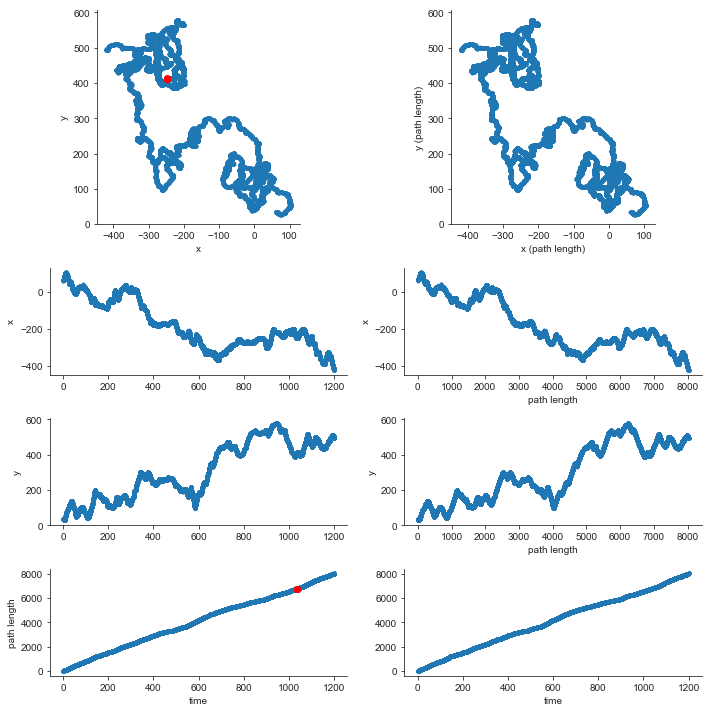

In [445]:
fig, axs = plt.subplots(4, 2, figsize=(10,10), gridspec_kw={'height_ratios':[2,1,1,1]})

axs[0,0].plot(x,y,'.-')
axs[0,0].plot(x[ev>0],y[ev>0],'ro')
axs[0,0].set_aspect('equal')
axs[0,0].set_xlabel('x'); axs[0,0].set_ylabel('y')

axs[1,0].plot(t,x,'.-')
axs[1,0].set_ylabel('x')

axs[2,0].plot(t,y,'.-')
axs[2,0].set_ylabel('y')

axs[3,0].plot(t,p,'.-')
axs[3,0].plot(t[ev>0],p[ev>0],'ro')
axs[3,0].set_xlabel('time'); axs[3,0].set_ylabel('path length')

axs[0,1].plot(x_eqlp,y_eqlp,'.-')
axs[0,1].set_aspect('equal')
axs[0,1].set_xlabel('x (path length)'); axs[0,1].set_ylabel('y (path length)')

axs[1,1].plot(eqlp,x_eqlp,'.-')
axs[1,1].set_xlabel('path length');axs[1,1].set_ylabel('x')

axs[2,1].plot(eqlp,y_eqlp,'.-')
axs[2,1].set_xlabel('path length'); axs[2,1].set_ylabel('y')

axs[3,1].plot(t_eqlp,eqlp,'.-')
axs[3,1].set_xlabel('time'); axs[3,0].set_ylabel('path length')

fig.tight_layout()

for ax in axs:
    myAxisTheme(ax[0])
    myAxisTheme(ax[1])

In [446]:
def signedCurvature(x,y, sgwind, sgorder):
    dx = np.hstack((0,np.diff(x)))
    dy = np.hstack((0,np.diff(y)))
    
    ddx = np.hstack((0,np.diff(dx)))
    ddy = np.hstack((0,np.diff(dy)))
    
    k = (dx*ddy - dy*ddx) / (dx*dx + dy*dy)**(3/2)
    
    # filter
    from scipy.signal import savgol_filter
    
    # filter
    mask = ~np.isnan(k)
    k_filt = k.copy()
    k_filt[mask] = savgol_filter(k[mask], sgwind, sgorder) 

    return k_filt

### Compare across flies

In [447]:
import scipy.stats as sts

# parameters for event triggered curvature plots
pathWind = int(fps*60*0.5)
maxT = 20
maxP = 40
numBinsP = 12#maxP/5
numBinsT = 12

# for averages within a fly, across paths:
rangeP = (0,maxP)
rangeT = (0,maxT)
usestat = 'median'
   
# collect data from all flies
allpathDists = []
allpathCurvs = []
allpathTimes = []

allpathDistsRand = []
allpathCurvsRand = []

# collect per fly averages
avPathCurvature = np.nan*np.ones((numFlies,numBinsP))
avTCurvature = np.nan*np.ones((numFlies,numBinsT))
avPathCurvatureRand = np.nan*np.ones((numFlies,numBinsP))

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    x = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    y = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    t = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    # derrived
    p = np.hstack((0,np.cumsum(np.hypot(np.diff(x),np.diff(y)))))

    # interpolate
    t2p = interpol.interp1d(p,t)
    x2p = interpol.interp1d(p,x)
    y2p = interpol.interp1d(p,y)
    ev2p = interpol.interp1d(p,ev)

    eqlp = np.linspace(p[0],p[-1],len(p))

    t_eqlp = t2p(eqlp)
    x_eqlp = x2p(eqlp)
    y_eqlp = y2p(eqlp)
    ev_eqlp = ev2p(eqlp)

    pathDists = []
    pathCurvs = []
    pathTimes = []
    
    pathDistsRand = []
    pathCurvsRand = []

    k = signedCurvature(x_eqlp, y_eqlp, 15, 3)

    if sum(ev_eqlp) <= evLevel*0.2:
        print('fly {}, no event'.format(fly+1))
        continue
        
    # real event starts
    evStart = np.where(ev_eqlp>evLevel*0.2)[0]
    
    if sum(np.diff(evStart)>1) > 0:
        evStart = np.hstack((evStart[0],evStart[np.where(np.diff(evStart)>1)[0]+1]))
        # sample random event starts for comparison
        randStart = np.random.uniform(0, len(ev_eqlp), len(evStart))
        randStart = np.sort(np.round(randStart).astype('int'))
        print('fly {}, {} events'.format(fly+1, len(evStart)))
        
        for i, es in enumerate(evStart):
            pathSt = es
            pathEd = getPathEnd(i, evStart, len(x_eqlp), pathWind)
            if np.isnan(pathEd): continue

            pathX = x_eqlp[pathSt:pathEd]-x_eqlp[pathSt]
            pathY = y_eqlp[pathSt:pathEd]-y_eqlp[pathSt]
            pathT = t_eqlp[pathSt:pathEd]-t_eqlp[pathSt]
            pathDist = np.hypot(pathX, pathY)
            pathCurv = abs(k[pathSt:pathEd])

            pathDists += list(pathDist)
            pathCurvs += list(pathCurv)
            pathTimes += list(pathT)

        for i, es in enumerate(randStart):
            pathSt = es
            pathEd = getPathEnd(i, randStart, len(x_eqlp), pathWind)
            if np.isnan(pathEd):continue

            pathX = x_eqlp[pathSt:pathEd]-x_eqlp[pathSt]
            pathY = y_eqlp[pathSt:pathEd]-y_eqlp[pathSt]
            pathDist = np.hypot(pathX, pathY)
            pathCurv = abs(k[pathSt:pathEd])

            pathDistsRand += list(pathDist)
            pathCurvsRand += list(pathCurv)
    else: #just one event
        evStart = evStart[0]
        randStart = np.random.uniform(0, len(ev_eqlp), 1)[0].astype('int')
        print('fly {}, 1 event'.format(fly+1))
        
        if evStart + pathWind > len(x_eqlp):
            continue
        else: pathEd = evStart+pathWind

        pathX = x_eqlp[evStart:pathEd]-x_eqlp[evStart]
        pathY = y_eqlp[evStart:pathEd]-y_eqlp[evStart]
        pathT = t_eqlp[evStart:pathEd]-t_eqlp[evStart]
        pathDist = np.hypot(pathX, pathY)
        pathCurv = abs(k[evStart:pathEd])

        pathDists += list(pathDist)
        pathCurvs += list(pathCurv)
        pathTimes += list(pathT)

        if randStart + pathWind > len(x_eqlp):
            continue
        else: pathEd = randStart+pathWind
            
        pathX = x_eqlp[randStart:pathEd]-x_eqlp[randStart]
        pathY = y_eqlp[randStart:pathEd]-y_eqlp[randStart]
        pathDist = np.hypot(pathX, pathY)
        pathCurv = abs(k[randStart:pathEd])
        
        pathDistsRand += list(pathDist)
        pathCurvsRand += list(pathCurv)
    
    print(evStart)
    
    meanPathCurv, edgsP, binnum = sts.binned_statistic(\
                        pathDists, pathCurvs, statistic=usestat, bins=numBinsP, range=rangeP)

    meanTCurv, edgsT, binnum = sts.binned_statistic(\
                        pathTimes, pathCurvs, statistic=usestat, bins=numBinsT, range=rangeT)
    
    meanPathCurvRand, edgsP, binnum = sts.binned_statistic(\
                        pathDistsRand, pathCurvsRand, statistic=usestat, bins=numBinsP, range=rangeP)
    
    avPathCurvature[fly,:] = meanPathCurv
    avTCurvature[fly,:] = meanTCurv
    avPathCurvatureRand[fly,:] = meanPathCurvRand
    
    binlocsP = edgsP[:-1] + np.mean(np.diff(edgsP))/2
    binlocsT = edgsT[:-1] + np.mean(np.diff(edgsT))/2
    
    allpathDists += list(pathDists)
    allpathCurvs += list(pathCurvs)
    allpathTimes += list(pathTimes)
    
    allpathDistsRand += list(pathDistsRand)
    allpathCurvsRand += list(pathCurvsRand)


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


fly 1, no event
fly 2, 1 event
20288
fly 3, 3 events
[ 8239 17379 18337]
fly 4, 2 events
[18808 19672]
fly 5, no event
fly 6, 4 events
[ 9406 13131 13772 23764]
fly 7, 2 events
[2484 5499]
fly 8, 1 event
17337
fly 9, no event
fly 10, 1 event
fly 11, 2 events
[14452 23616]
fly 12, 1 event
14897


In [448]:
allmeanPathCurv, edgsP, binnum = sts.binned_statistic(\
                        allpathDists, allpathCurvs, statistic=usestat, bins=numBinsP, range=rangeP)

allmeanTCurv, edgsT, binnum = sts.binned_statistic(\
                    allpathTimes, allpathCurvs, statistic=usestat, bins=numBinsT, range=rangeT)

allmeanPathCurvRand, edgsP, binnum = sts.binned_statistic(\
                        allpathDistsRand, allpathCurvsRand, statistic=usestat, bins=numBinsP, range=rangeP)

In [449]:
dat = [avPathCurvature, avTCurvature, avPathCurvatureRand]
xax = [binlocsP,binlocsT,binlocsP]
np.save(analysisDir + 'curvyness/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
        +'_curvatureAverRewardDat_{}perFlyAndAcross_pl{}mm_t{}s_n{}'.format(usestat, maxP, maxT, len(flyIDs)) 
        +selectionTag, dat)
np.save(analysisDir + 'curvyness/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
        +'_curvatureAverRewardBinLocs_{}perFlyAndAcross_pl{}mm_t{}s_n{}'.format(usestat, maxP, maxT, len(flyIDs)) 
        +selectionTag, xax)

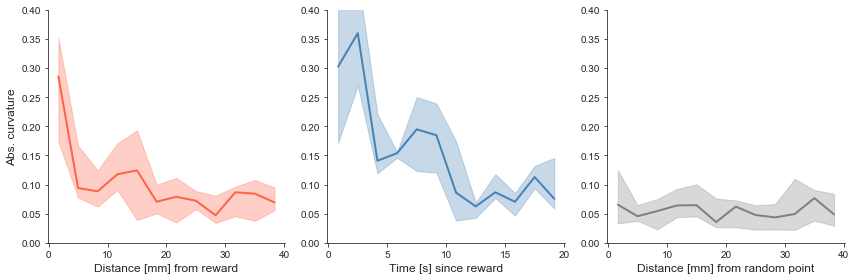

In [450]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cols = ['tomato', 'steelblue','grey']
for i in range(3):
    [qt25, qt50, qt75] = np.nanpercentile(dat[i],[25,50,75],axis=0)
    axs[i].plot(xax[i],qt50, linewidth=2,color=cols[i], label='',)
    axs[i].fill_between(xax[i],qt25, qt75, color=cols[i], linewidth=1,alpha=0.3)

for ax in axs:
    myAxisTheme(ax)
    ax.set_ylim(0,0.4)
axs[0].set_ylabel('Abs. curvature', fontsize=12)
axs[0].set_xlabel('Distance [mm] from reward', fontsize=12)
axs[1].set_xlabel('Time [s] since reward', fontsize=12)
axs[2].set_xlabel('Distance [mm] from random point', fontsize=12)
    
fig.tight_layout()
fig.savefig(analysisDir + 'curvyness/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
      '_curvatureAverReward_{}perFlyAndAcross_pl{}mm_t{}s_n{}'.format(usestat, maxP, maxT, len(flyIDs)) +selectionTag+'.pdf')

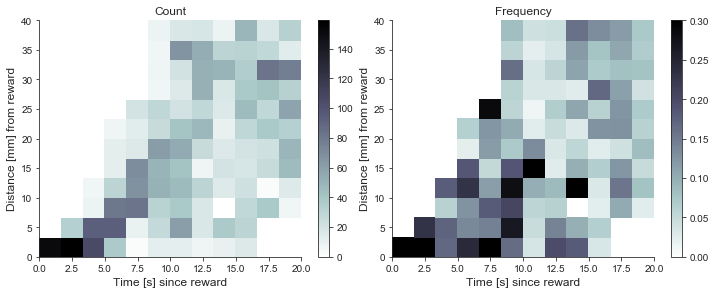

In [451]:
pathCurvCover, edgp, edgt, binnum = sts.binned_statistic_2d(\
            allpathDists, allpathTimes, None, statistic='count', \
            bins=[numBinsP, numBinsT], range=[rangeP, rangeT])

pathCurvMap, edgp, edgt, binnum = sts.binned_statistic_2d(\
            allpathDists, allpathTimes, allpathCurvs, statistic=usestat, \
            bins=[numBinsP, numBinsT], range=[rangeP, rangeT])

fig, axs = plt.subplots(1,2,figsize=(10,4))

cb = axs[0].pcolormesh(edgt, edgp, pathCurvCover, vmin=0, cmap='bone_r')
plt.colorbar(cb, ax = axs[0])
axs[0].set_title('Count')

cb = axs[1].pcolormesh(edgt, edgp, pathCurvMap, vmin=0, vmax=0.3, cmap='bone_r')
plt.colorbar(cb, ax = axs[1])
axs[1].set_title('Frequency')

fig.tight_layout()

for ax in axs:
    ax.set_xlabel('Time [s] since reward', fontsize=12)
    ax.set_ylabel('Distance [mm] from reward', fontsize=12)
    myAxisTheme(ax)

fig.savefig(analysisDir + 'curvyness/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
      '_curvatureAverRewardMaps_{}perFlyAndAcross_pl{}mm_t{}s_n{}'.format(usestat, maxP, maxT, len(flyIDs)) +selectionTag+'.pdf')

## Segment paths into "arcs" using curvature sign flips

In [452]:
try:
    mkdir(analysisDir + 'PIanalysis/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [453]:
FOAllFlies_df.head()

,flyID,trial,trialtype,reinforcement,protocol,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.000000,0.000000,60.622,60.622,35.0,35.0,0.0
1,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.050004,0.000000,60.622,60.622,35.0,35.0,0.0
2,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.100008,0.000000,60.622,60.622,35.0,35.0,0.0
3,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.150012,0.000000,60.622,60.622,35.0,35.0,0.0
4,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.200016,0.984213,60.622,60.622,35.0,35.0,0.0


In [454]:
fly = 0
st = int(fps*60*0)
ed = int(fps*60*20)
querystring = '(flyID == "'+flyIDs[fly]+'")'
x = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()[st:ed]
y = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()[st:ed]
a = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()[st:ed]
ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()[st:ed]
t = FOAllFlies_df.query(querystring)['time'].values.squeeze()[st:ed]

# derrived
p = np.hstack((0,np.cumsum(np.hypot(np.diff(x),np.diff(y)))))

t2p = interpol.interp1d(p,t)
x2p = interpol.interp1d(p,x)
y2p = interpol.interp1d(p,y)
a2p = interpol.interp1d(p,a)
ev2p = interpol.interp1d(p,ev)

eqlp = np.linspace(p[0],p[-1],len(p))

t_eqlp = t2p(eqlp)
x_eqlp = x2p(eqlp)
y_eqlp = y2p(eqlp)
a_eqlp = a2p(eqlp)
ev_eqlp = ev2p(eqlp)

k = signedCurvature(x_eqlp, y_eqlp, 15, 3)

cthr = 0.1
k_thresh = k.copy()
k_thresh[abs(k) < cthr] = 0

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less


In [455]:
pathWind = int(fps*60*0.25)

# real event starts
evStart = np.where(ev_eqlp>evLevel*0.2)[0]

if sum(np.diff(evStart)>1) > 0:
    print(evStart)
    evStart = np.hstack((evStart[0],evStart[np.where(np.diff(evStart)>1)[0]+1]))
    numEv = len(evStart)
    
    fig, axs = plt.subplots(numEv,3, figsize=(15,5*(numEv)), gridspec_kw = {'width_ratios':[1,1, 1]})

    for i, es in enumerate(evStart):
        pathSt = es
        pathEd = getPathEnd(i, evStart, len(x_eqlp), pathWind)
        if np.isnan(pathEd):
            print('trunkated path')
            continue

        pathX = x_eqlp[pathSt:pathEd]-x_eqlp[pathSt]
        pathY = y_eqlp[pathSt:pathEd]-y_eqlp[pathSt]
        pathEv = ev_eqlp[pathSt:pathEd]
        pathT = t_eqlp[pathSt:pathEd]-t_eqlp[pathSt]
        pathDist = np.hypot(pathX, pathY)
        pathCurv = k[pathSt:pathEd]
        pathCurv2 = k_thresh[pathSt:pathEd]

        axs[i,0].plot(pathX, pathY, color='grey')
        axs[i,0].scatter(pathX, pathY, c=pathCurv, s=10*np.ones(len(pathX)), cmap='coolwarm', vmin=-0.3, vmax=0.3)
        axs[i,0].plot(pathX[pathEv>0], pathY[pathEv>0],'o', color='hotpink')
        circ = plt.Circle((pathX[0], pathY[0]), 30, linestyle='dashed', fill=False, edgecolor='grey')
        axs[i,0].add_artist(circ)
        axs[i,0].set_aspect('equal')
        
        axs[i,1].plot(pathX, pathY, color='grey')
        axs[i,1].scatter(pathX, pathY, c=pathCurv2, s=10*np.ones(len(pathX)), cmap='coolwarm', vmin=-0.3, vmax=0.3)
        axs[i,1].plot(pathX[pathEv>0], pathY[pathEv>0],'o', color='hotpink')
        circ = plt.Circle((pathX[0], pathY[0]), 30, linestyle='dashed', fill=False, edgecolor='grey')
        axs[i,1].add_artist(circ)
        axs[i,1].set_aspect('equal')

        axs[i,2].plot(pathT,pathCurv, color='skyblue')
        axs[i,2].plot(pathT,pathCurv2, color='grey')
        axs[i,2].scatter(pathT, pathCurv2, c=pathDist, s=10*np.ones(len(pathX)), cmap='magma_r', vmin=0, vmax=30)
        axs[i,2].set_ylim(-0.7, 0.7)
        for ax in axs[i,:]:
            myAxisTheme(ax)


#### threshold curvature: if close to 0, set to 0.
Could implement schmitt trigger algorithm here

In [456]:
windSec = 20
pathWind = int(fps*windSec)

turnsDf = pd.DataFrame()
keylistTurns = ['flyID','turnSize','turnAngleSt','turnAngleEd','turnLengthT','turnLengthP','turnStObjDist'] 

runsDf = pd.DataFrame()
keylistRuns = ['flyID','runLength','runStT','runEdT','runStDist','runEdDist','runStObjDist'] 

cthr = 0.1

In [457]:
def processPathFrag(pathSt, pathEd, turnsDf, runsDf, plotFig):
    pathX = x_eqlp[pathSt:pathEd]-x_eqlp[pathSt]
    pathY = y_eqlp[pathSt:pathEd]-y_eqlp[pathSt]
    pathEv = ev_eqlp[pathSt:pathEd]
    pathT = t_eqlp[pathSt:pathEd]-t_eqlp[pathSt]
    pathoD = oD_eqlp[pathSt:pathEd]
    pathDist = np.hypot(pathX, pathY)
    pathLength = np.cumsum(np.hypot(np.diff(pathX), np.diff(pathY)))
    pathCurv = k_thresh[pathSt:pathEd]

    pathAng = a_eqlp[pathSt:pathEd]

    # body angle relative to reward location
    _, _, pathGamma, _, _ = relationToObject(pathT, pathX, pathY, pathAng, (0,0))

    # find turns based on curvature
    # find turn starts
    ccwTurnSt = np.where((np.hstack((0, np.diff(np.sign(pathCurv))))>0).astype('bool') * np.sign(pathCurv)>0)[0]-1
    cwTurnSt = np.where((np.hstack((0, np.diff(np.sign(pathCurv))))<0).astype('bool') * np.sign(pathCurv)<0)[0]-1

    # find turn ends
    ccwTurnEd = np.where((np.hstack((np.diff(np.sign(pathCurv)),0))<0).astype('bool') * np.sign(pathCurv)>0)[0]
    cwTurnEd = np.where((np.hstack((np.diff(np.sign(pathCurv)),0))>0).astype('bool') * np.sign(pathCurv)<0)[0]

    # check for inconsistencies
    if ccwTurnSt[0] > ccwTurnEd[0]:
        ccwTurnEd = ccwTurnEd[1:]
    for i, ccwt in enumerate(ccwTurnSt):
        if i > len(ccwTurnEd)-1:
            ccwTurnSt[i]= -1
        elif ccwt > ccwTurnEd[i]:
            ccwTurnEd[i]= -1
    ccwTurnSt = ccwTurnSt[ccwTurnSt>=0]
    ccwTurnEd = ccwTurnEd[ccwTurnEd>=0]

    if cwTurnSt[0] > cwTurnEd[0]:
        cwTurnEd = cwTurnEd[1:]
    for i, cwt in enumerate(cwTurnSt):
        if i > len(cwTurnEd)-1:
            cwTurnSt[i]= -1
        elif cwt > cwTurnEd[i]:
            cwTurnEd[i]= -1
    cwTurnSt = cwTurnSt[cwTurnSt>=0]
    cwTurnEd = cwTurnEd[cwTurnEd>=0]

    turnSt = sorted(list(ccwTurnSt) + list(cwTurnSt))
    turnEd = sorted(list(ccwTurnEd) + list(cwTurnEd))

    # compute relative heading direction vectors 
    turnSize = np.zeros(len(turnSt))
    for i in range(len(turnSt)):
        vSt = (np.cos(pathGamma[turnSt[i]]+np.pi), np.sin(pathGamma[turnSt[i]]+np.pi))
        vEd = (np.cos(pathGamma[turnEd[i]]+np.pi), np.sin(pathGamma[turnEd[i]]+np.pi))
        turnSize[i] = np.arccos( np.dot(vSt, vEd) / (np.hypot(vSt[0],vSt[1])*np.hypot(vEd[0],vEd[1])) )

    singleTurndf = pd.DataFrame({
        'flyID': flyIDs[fly],
        'turnSize': list(turnSize),
        'turnAngleSt': list(pathGamma[turnSt]),
        'turnAngleEd': list(pathGamma[turnEd]),
        'turnLengthT': list(np.asarray(pathT[turnEd])-np.asarray(pathT[turnSt])),
        'turnLengthP': list(np.asarray(pathLength[turnEd])-np.asarray(pathLength[turnSt])),
        'turnStObjDist': list(pathoD[turnSt])
    })
    turnsDf = turnsDf.append(singleTurndf)
        
    runSt = np.asarray(turnEd)[np.where(np.asarray(turnSt[1:])-np.asarray(turnEd[:-1])>0)[0]]
    runEd = np.asarray(turnSt)[np.where(np.asarray(turnSt[1:])-np.asarray(turnEd[:-1])>0)[0]+1]
    
    runLengths = np.zeros(len(runSt))
    for i, st in enumerate(runSt):
        runLengths[i] = np.sum(np.hypot(np.diff(pathX[st:runEd[i]]), np.diff(pathY[st:runEd[i]])))

    singleRundf = pd.DataFrame({
        'flyID': flyIDs[fly],
        'runLength': runLengths,
        'runStT': pathT[runSt],
        'runEdT': pathT[runEd],
        'runStDist': pathDist[runSt],
        'runEdDist': pathDist[runEd],
        'runStObjDist': pathoD[runEd]
    })
    runsDf = runsDf.append(singleRundf)
    
    
    # Visualisation of turn detection and performance check
    if plotFig:
        fig, axs = plt.subplots(1,2, figsize=(12,4), gridspec_kw={'width_ratios':[2.5,1]})

        axs[0].plot(pathT,pathCurv)
        axs[0].plot(pathT,np.sign(pathCurv),'grey')
        axs[0].plot(pathT[ccwTurnSt], np.sign(pathCurv)[ccwTurnSt],'ro')
        axs[0].plot(pathT[cwTurnSt], np.sign(pathCurv)[cwTurnSt],'co')
        axs[0].plot(pathT[ccwTurnEd], np.sign(pathCurv)[ccwTurnEd],'r.')
        axs[0].plot(pathT[cwTurnEd], np.sign(pathCurv)[cwTurnEd],'c.')

        axs[1].plot(pathX, pathY, 'grey')
        axs[1].set_aspect('equal')
        for i, t in enumerate(ccwTurnSt):
            axs[1].plot(pathX[t:ccwTurnEd[i]],pathY[t:ccwTurnEd[i]], linewidth=2, color='red')   
        for i, t in enumerate(cwTurnSt):
            axs[1].plot(pathX[t:cwTurnEd[i]],pathY[t:cwTurnEd[i]], linewidth=2, color='blue')

        for ax in axs: myAxisTheme(ax)

    return runsDf, turnsDf

fly 1
fly 2
20288
400
fly 3
[ 8239 17379 18337]


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


fly 4
[18808 19672]
fly 5
fly 6
[ 9406 13131 13772 23764]
trunkated path
fly 7
[2484 5499]
fly 8
17337
400
fly 9
fly 10
23943
fly 11
[14452 23616]
trunkated path
fly 12
14897
400


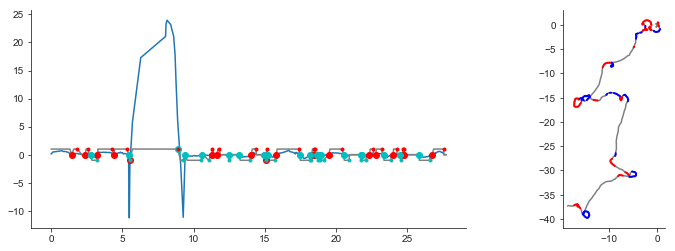

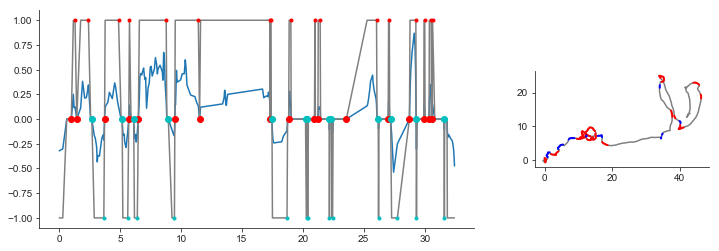

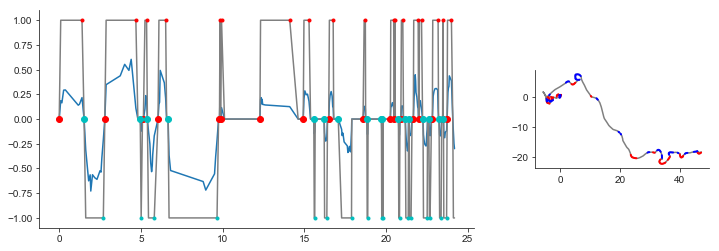

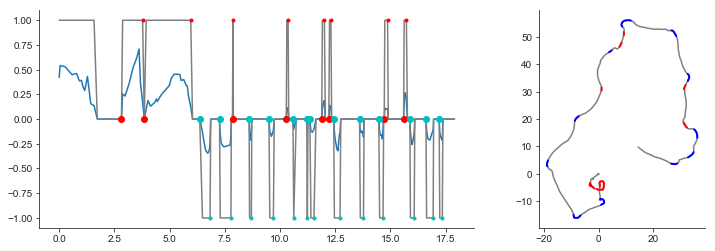

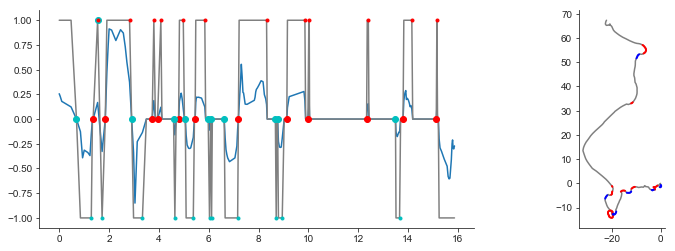

In [458]:
for fly in range(numFlies):
    print('fly {}'.format(fly+1))
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    flyDf = FOAllFlies_df.query(querystring)
    x = flyDf['xPos'].values.squeeze()
    y = flyDf['yPos'].values.squeeze()
    a = flyDf['headingAngle'].values.squeeze()
    ev = flyDf['rEvents'].values.squeeze()
    t = flyDf['time'].values.squeeze()

    # derrived
    p = np.hstack((0,np.cumsum(np.hypot(np.diff(x),np.diff(y)))))
    objDist = np.hypot(flyDf['xPosInMiniarena'].values.squeeze(), flyDf['yPosInMiniarena'].values.squeeze())

    t2p = interpol.interp1d(p,t)
    x2p = interpol.interp1d(p,x)
    y2p = interpol.interp1d(p,y)
    a2p = interpol.interp1d(p,a)
    ev2p = interpol.interp1d(p,ev)
    oD2p = interpol.interp1d(p, objDist)
    
    eqlp = np.linspace(p[0],p[-1],len(p))

    t_eqlp = t2p(eqlp)
    x_eqlp = x2p(eqlp)
    y_eqlp = y2p(eqlp)
    a_eqlp = a2p(eqlp)
    ev_eqlp = ev2p(eqlp)
    oD_eqlp = oD2p(eqlp)

    k = signedCurvature(x_eqlp, y_eqlp, 15, 3)
    
    k_thresh = k.copy()
    k_thresh[abs(k) < cthr] = 0

    if sum(ev_eqlp) <= evLevel*0.2:
        continue
        
    # event starts
    evStart = np.where(ev_eqlp>evLevel*0.2)[0]
    
    if sum(np.diff(evStart)>1) > 0:
        evStart = np.hstack((evStart[0],evStart[np.where(np.diff(evStart)>1)[0]+1]))
        print(evStart)
        numEv = len(evStart)
        plotFig = True

        for i, es in enumerate(evStart):
            pathSt = es
            pathEd = getPathEnd(i, evStart, len(x_eqlp), pathWind)
            if np.isnan(pathEd):
                print('trunkated path')
                continue
            runsDf, turnsDf = processPathFrag(pathSt, pathEd, turnsDf, runsDf, plotFig)
            plotFig = False
            
    else:
        evStart = evStart[0]
        pathSt = evStart
        print(evStart)
        numEv = 1
        if evStart + pathWind > len(x_eqlp):
            continue
        else: pathEd = evStart+pathWind
        print(pathEd - pathSt)
        runsDf, turnsDf = processPathFrag(pathSt, pathEd, turnsDf, runsDf, False)  

turnsDf = turnsDf[keylistTurns]
runsDf = runsDf[keylistRuns]

In [459]:
maxDist = 70 # 60 # 80 # 
distBinNum = int(maxDist/10 + 1)
distBins = np.linspace(0,maxDist,distBinNum)
distBinInds = np.digitize(runsDf['runStDist'], distBins, right=True)
runsDf['binnedRunStDist'] = distBinInds

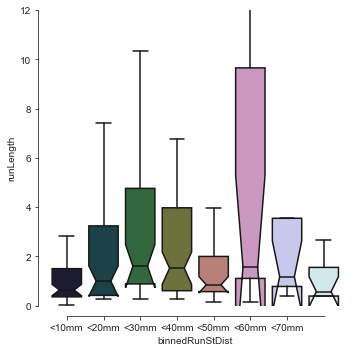

In [460]:
minRunL = 0
minObjDist = 6
runplotdf = runsDf.query('runLength > {} and runStDist <= 80 and runStObjDist > {}'.format(minRunL,minObjDist))

import seaborn as sns

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.set_ylim(0,12)
axs = sns.boxplot(x="binnedRunStDist", y="runLength",data=runplotdf, palette="cubehelix", ax = axs, notch=True,fliersize=0)
sns.despine(offset=10, trim=True)

xinds = range(len(distBins))
plt.xticks(xinds[:-1], ['<{}mm'.format((i+1)*10) for i in xinds[:-1]]);

fig.tight_layout()
fig.savefig(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
      '_pathLengthVsDistance_pooledOverFliesAndPaths_wind{}s_n{}'.format(windSec,len(flyIDs)) +selectionTag+'.pdf')

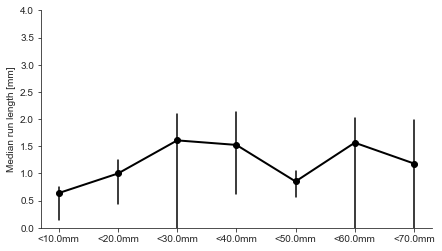

In [461]:
minSizeDf = runplotdf.query('runStObjDist > {}'.format(minObjDist))
distBins = np.linspace(0,maxDist,distBinNum)
avRunLen, edgs, binn = sts.binned_statistic(minSizeDf['runStDist'], minSizeDf['runLength'],
                                              statistic='median',bins=distBins)#, range=rangeP)

fig, axs = plt.subplots(1,1,figsize=(7,4))
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

medRunDistCI = np.zeros((len(distBins)-1,3))
ciLevel = 0.95

for i, db in enumerate(distBins[1:]):
    samples = minSizeDf.query('binnedRunStDist == {}'.format(i+1))['runLength'].values
    bsr = bs.bootstrap(samples, stat_func=bs_stats.median, alpha=1-ciLevel)
    medRunDistCI[i,0] = bsr.value
    medRunDistCI[i,1] = bsr.lower_bound
    medRunDistCI[i,2] = bsr.upper_bound
    axs.plot([db,db], [medRunDistCI[i,1],medRunDistCI[i,2]],'k-')
axs.plot(distBins[1:], medRunDistCI[:,0],'ko-',linewidth=2)
xinds = edgs[1:]
plt.xticks(xinds[:], ['<{}mm'.format((i)) for i in xinds[:]])
axs.set_ylim(0,4)
axs.set_ylabel('Median run length [mm]')
myAxisTheme(axs)

fig.savefig(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
      '_pathLengthVsDistanceMedCI_pooledOverFliesAndPaths_wind{}s_n{}'.format(windSec,len(flyIDs)) 
            +selectionTag+'.pdf')
np.save(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
        '_pathLengthVsDistanceMedCI_pooledOverFliesAndPaths_wind{}s_n{}'.format(windSec, len(flyIDs))+
        selectionTag, medRunDistCI)

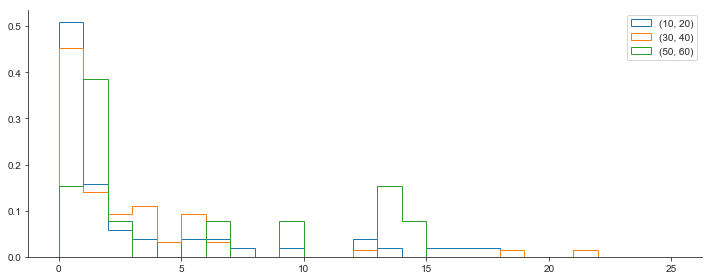

In [462]:
fig, axs = plt.subplots(1,1,figsize=(10,4))

distRanges = [(10,20),(30,40),(50,60)]
for i, dRange in enumerate(distRanges):
    rangeDf = runsDf.query('runLength > {} and runStDist >= {} and runStDist < {} and runStObjDist > {}'.format(minRunL, dRange[0],dRange[1],minObjDist))

    axs.hist(rangeDf['runLength'] ,bins=25, range=(0,25), histtype='step',density=True)
myAxisTheme(axs)
axs.legend(list(distRanges))
fig.tight_layout()
#fig.savefig(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
#      '_runLengthDistribution_pooledOverFliesAndPaths_n{}'.format(len(flyIDs)) +selectionTag+'.pdf')

#### Relative heading pre/post turn

In [463]:
def stylePolarPlot(titlestr,ax,ytickvals):
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_title(titlestr)
    ax.set_rlabel_position(225)
    ax.set_xlim(0, 2*np.pi)
    ax.set_yticks(ytickvals)
    ax.set_theta_zero_location("N")
    #ax.spines['polar'].set_visible(False)

In [464]:
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec

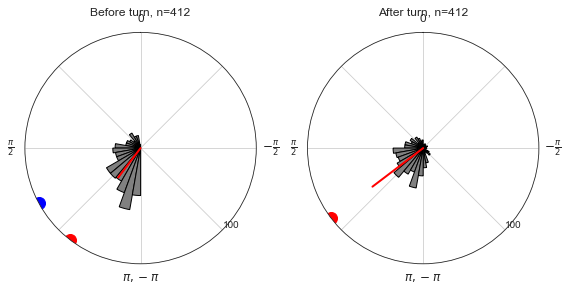

In [465]:
nbins = 36
rangebins = (-np.pi, np.pi)
ytickvals = [100, 200, 300, 400]
if gridSize == 240:
    if windSec ==20: maxy = 100
    else: maxy = 70
else:
    if windSec ==20: maxy = 200#600
    else: maxy = 650

tDf = turnsDf.query('turnStObjDist > {}'.format(minObjDist))

turnsHeadings = np.zeros((2,len(tDf['turnAngleSt'].values)))
turnsHeadings[0,:] = tDf['turnAngleSt'].values
turnsHeadings[1,:] = tDf['turnAngleEd'].values

goalPos = np.sign(turnsHeadings[0,:])
turnsHeadings[0,:][goalPos<0] = -1*turnsHeadings[0,:][goalPos<0]
turnsHeadings[1,:][goalPos<0] = -1*turnsHeadings[1,:][goalPos<0]

fig= plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1, projection='polar')
ax.hist(turnsHeadings[0,:] ,bins=nbins, range=rangebins, facecolor='grey',edgecolor='k')
stylePolarPlot('Before turn, n={}'.format(len(turnsHeadings[0,:])),ax,ytickvals)
meandir, meanlen = circmeanvec(turnsHeadings[0,:], np.ones(len(turnsHeadings[0,:])), high=np.pi, low=0)
ax.plot([0,meandir], [0,maxy*meanlen],'r-', linewidth=2)
ax.plot(meandir, maxy,'ro',markersize=12)
ax.plot(np.mean(turnsHeadings[0,:]), maxy,'bo',markersize=12)
ax.set_ylim(0,maxy)

ax = fig.add_subplot(1,2,2, projection='polar')
ax.hist(turnsHeadings[1,:],bins=nbins, range=rangebins, facecolor='grey',edgecolor='k')
stylePolarPlot('After turn, n={}'.format(len(turnsHeadings[1,:])),ax,ytickvals)
meandir, meanlen = circmeanvec(turnsHeadings[1,:],np.ones(len(turnsHeadings[1,:])), high=np.pi, low=-np.pi)
ax.plot([0,meandir], [0,maxy*meanlen],'r-', linewidth=2)
ax.plot(meandir, maxy,'ro',markersize=12)
ax.set_ylim(0,maxy)

fig.tight_layout()
fig.savefig(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
      '_relHeadingBeforeAfter_pooledOverFliesAndPaths_wind{}s_n{}'.format(windSec, len(flyIDs)) +selectionTag+'.pdf')

np.save(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
        '_relHeadingBeforeAfter_pooledOverFliesAndPaths_wind{}s_n{}'.format(windSec, len(flyIDs)) +selectionTag, turnsDf)

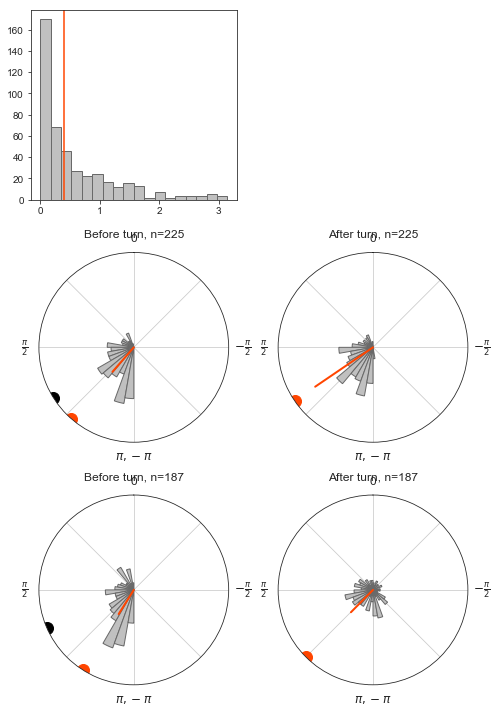

In [466]:
nbins = 36
rangebins = (-np.pi, np.pi)
ytickvals = [100, 200, 300, 400]

if gridSize == 240:
    if windSec ==20: ylimvals = [50, 40]
    else:  ylimvals = [350, 300]
else:
    if windSec ==20: ylimvals = [100, 60]#[250, 200]
    else:  ylimvals = [550, 500]

turnsizecut = np.pi/8

turnSizeRanges = [(0,turnsizecut),(turnsizecut,np.pi)]

fig= plt.figure(figsize=(7, 3+3.5*len(turnSizeRanges)))

#turn size distribution:
ax = fig.add_subplot(len(turnSizeRanges)+1,2,1)
ax.hist(turnsDf['turnSize'].values,bins=18, range=(0,np.pi), facecolor='silver',edgecolor='dimgrey')
ax.axvline(turnsizecut,0,1,color='orangered')

for i, tsRange in enumerate(turnSizeRanges):

    minSizeDf = turnsDf.query('turnSize >= {} and turnSize < {} and turnStObjDist > {}'.format(tsRange[0],tsRange[1],minObjDist))
    turnsHeadings = np.zeros((2,len(minSizeDf['turnAngleSt'].values)))

    turnsHeadings[0,:] = minSizeDf['turnAngleSt'].values
    turnsHeadings[1,:] = minSizeDf['turnAngleEd'].values

    goalPos = np.sign(turnsHeadings[0,:])
    turnsHeadings[0,:][goalPos<0] = -1*turnsHeadings[0,:][goalPos<0]
    turnsHeadings[1,:][goalPos<0] = -1*turnsHeadings[1,:][goalPos<0]

    ax = fig.add_subplot(len(turnSizeRanges)+1,2,2*i+3, projection='polar')
    ax.hist(turnsHeadings[0,:] ,bins=nbins, range=rangebins, facecolor='silver',edgecolor='dimgrey')
    stylePolarPlot('Before turn, n={}'.format(len(turnsHeadings[0,:])),ax,ytickvals)
    meandir, meanlen = circmeanvec(turnsHeadings[0,:], np.ones(len(turnsHeadings[0,:])), high=np.pi, low=0)
    ax.plot([0,meandir], [0,ylimvals[i]*meanlen],'-', color='orangered',linewidth=2)
    ax.plot(meandir, ylimvals[i],'o',color='orangered',markersize=12)
    ax.plot(np.mean(turnsHeadings[0,:],0), ylimvals[i],'ko',markersize=12)
    ax.set_ylim(0,ylimvals[i])

    ax = fig.add_subplot(len(turnSizeRanges)+1,2,2*i+4, projection='polar')
    ax.hist(turnsHeadings[1,:],bins=nbins, range=rangebins,facecolor='silver',edgecolor='dimgrey')
    stylePolarPlot('After turn, n={}'.format(len(turnsHeadings[1,:])),ax,ytickvals)
    meandir, meanlen = circmeanvec(turnsHeadings[1,:], np.ones(len(turnsHeadings[1,:])), high=np.pi, low=-np.pi)
    ax.plot([0,meandir], [0,ylimvals[i]*meanlen],'-',color='orangered',linewidth=2)
    ax.plot(meandir, ylimvals[i],'o',color='orangered',markersize=12)
    ax.set_ylim(0,ylimvals[i])

fig.tight_layout()
fig.savefig(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
      '_relHeadingBeforeAfter_pooledOverFliesAndPaths_wind{}s_turnSizeBinned_n{}'.format(windSec,len(flyIDs)) +selectionTag+'.pdf')

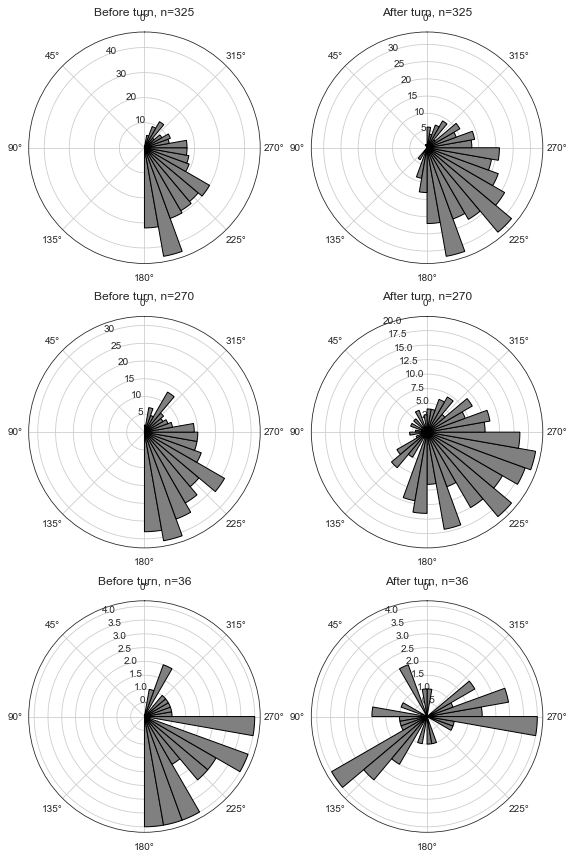

In [467]:
nbins = 36
rangebins = (-np.pi, np.pi)

turnLenRanges = [(0,1),(1,4),(4,10)]

fig= plt.figure(figsize=(8, 4*len(turnLenRanges)))

for i, tlRange in enumerate(turnLenRanges):
    minSizeDf = turnsDf.query('turnLengthP >= {} and turnSize < {} and turnStObjDist > {}'.format(tlRange[0],tlRange[1],minObjDist))
    turnsHeadings = np.zeros((2,len(minSizeDf['turnAngleSt'].values)))

    turnsHeadings[0,:] = minSizeDf['turnAngleSt'].values
    turnsHeadings[1,:] = minSizeDf['turnAngleEd'].values

    goalPos = np.sign(turnsHeadings[0,:])
    turnsHeadings[0,:][goalPos>0] = -1*turnsHeadings[0,:][goalPos>0]
    turnsHeadings[1,:][goalPos>0] = -1*turnsHeadings[1,:][goalPos>0]

    ax = fig.add_subplot(len(turnLenRanges),2,2*i+1, projection='polar')
    ax.hist(turnsHeadings[0,:] ,bins=nbins, range=rangebins, facecolor='grey',edgecolor='k')
    ax.set_theta_zero_location("N")
    ax.set_title('Before turn, n={}'.format(len(turnsHeadings[0,:])))
    #ax.set_ylim(0,500)

    ax = fig.add_subplot(len(turnLenRanges),2,2*i+2, projection='polar')
    ax.hist(turnsHeadings[1,:],bins=nbins, range=rangebins, facecolor='grey',edgecolor='k')
    ax.set_theta_zero_location("N")
    ax.set_title('After turn, n={}'.format(len(turnsHeadings[1,:])))
    #ax.set_ylim(0,500)

fig.tight_layout()
fig.savefig(analysisDir + 'PIanalysis/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol+
      '_relHeadingBeforeAfter_pooledOverFliesAndPaths_turnLengthBinned_wind{}s_n{}'.format(windSec,len(flyIDs)) +selectionTag+'.pdf')